## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:

LEARNING_RATE = 1e-3
EPOCHS = 5
BATCH_SIZE = 1024

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

"""
建立實驗組合
"""
optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]
reduce_lr_factor = [0.99, 0.5, 0.1]
redice_lr_patient = [3,5,10]

In [9]:
import itertools

"""
以迴圈方式遍歷組合來訓練模型
"""
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = "exp-optim-%s-reduce_factor-%s-reduce_patient-%s" % (str(optim), str(reduce_factor),str(reduce_patient))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.99, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalizatio

Epoch 2/5
50000/50000 [==============================] - 4s 77us/step - loss: 1.7832 - acc: 0.3818 - val_loss: 1.8500 - val_acc: 0.3685
Epoch 3/5
50000/50000 [==============================] - 4s 72us/step - loss: 1.6446 - acc: 0.4248 - val_loss: 1.7389 - val_acc: 0.3993
Epoch 4/5
50000/50000 [==============================] - 4s 75us/step - loss: 1.5688 - acc: 0.4524 - val_loss: 1.6551 - val_acc: 0.4210
Epoch 5/5
50000/50000 [==============================] - 3s 63us/step - loss: 1.5128 - acc: 0.4712 - val_loss: 1.6028 - val_acc: 0.4447
Numbers of exp: 4, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
ba

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 6s 111us/step - loss: 2.2794 - acc: 0.2600 - val_loss: 2.0837 - val_acc: 0.3213
Epoch 2/5
50000/50000 [==============================] - 3s 65us/step - loss: 1.7570 - acc: 0.3876 - val_loss: 1.8218 - val_acc: 0.3756
Epoch 3/5
50000/50000 [==============================] - 3s 64us/step - loss: 1.6327 - acc: 0.4292 - val_loss: 1.6918 - val_acc: 0.4039.6395 -
Epoch 4/5
50000/50000 [==============================] - 3s 70us/step - loss: 1.5623 - acc: 0.4517 - val_loss: 1.6472 - val_acc: 0.4208
Epoch 5/5
50000/50000 [==============================] - 4s 78us/step - loss: 1.5114 - acc: 0.4694 - val_loss: 1.5979 - val_acc: 0.4379
Numbers of exp: 8, reduce_factor: 0.10, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 3072)              0         
_____

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 7s 132us/step - loss: 1.8145 - acc: 0.3683 - val_loss: 1.7178 - val_acc: 0.4041
Epoch 2/5
50000/50000 [==============================] - 4s 71us/step - loss: 1.5407 - acc: 0.4532 - val_loss: 1.5779 - val_acc: 0.4466
Epoch 3/5
50000/50000 [==============================] - 3s 69us/step - loss: 1.4410 - acc: 0.4898 - val_loss: 1.6403 - val_acc: 0.4206
Epoch 4/5
50000/50000 [==============================] - 3s 69us/step - loss: 1.3696 - acc: 0.5135 - val_loss: 1.4992 - val_acc: 0.4689
Epoch 5/5
50000/50000 [==============================] - 3s 68us/step - loss: 1.3137 - acc: 0.5345 - val_loss: 1.6102 - val_acc: 0.4273
Numbers of exp: 12, reduce_factor: 0.50, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 3072)              0         
____________

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 7s 148us/step - loss: 1.8369 - acc: 0.3569 - val_loss: 1.9271 - val_acc: 0.3592
Epoch 2/5
50000/50000 [==============================] - 4s 71us/step - loss: 1.5743 - acc: 0.4388 - val_loss: 1.5950 - val_acc: 0.4326
Epoch 3/5
50000/50000 [==============================] - 4s 89us/step - loss: 1.4707 - acc: 0.4742 - val_loss: 1.6277 - val_acc: 0.4182
Epoch 4/5
50000/50000 [==============================] - 4s 71us/step - loss: 1.3984 - acc: 0.5017 - val_loss: 1.5806 - val_acc: 0.4381
Epoch 5/5
50000/50000 [==============================] - 4s 71us/step - loss: 1.3444 - acc: 0.5201 - val_loss: 1.5464 - val_acc: 0.4468
Numbers of exp: 16, reduce_factor: 0.10, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 3072)              0         
____________

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 8s 170us/step - loss: 1.8473 - acc: 0.3638 - val_loss: 2.5507 - val_acc: 0.2977
Epoch 2/5
50000/50000 [==============================] - 4s 76us/step - loss: 1.5443 - acc: 0.4512 - val_loss: 2.1225 - val_acc: 0.3211
Epoch 3/5
50000/50000 [==============================] - 4s 79us/step - loss: 1.4319 - acc: 0.4922 - val_loss: 2.4220 - val_acc: 0.2755
Epoch 4/5
50000/50000 [==============================] - 5s 97us/step - loss: 1.3488 - acc: 0.5208 - val_loss: 2.1664 - val_acc: 0.3303
Epoch 5/5
50000/50000 [==============================] - 4s 72us/step - loss: 1.2784 - acc: 0.5494 - val_loss: 1.9117 - val_acc: 0.3563
Numbers of exp: 20, reduce_factor: 0.99, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)              0         
___________

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 9s 183us/step - loss: 1.8250 - acc: 0.3682 - val_loss: 2.4772 - val_acc: 0.2665
Epoch 2/5
50000/50000 [==============================] - 4s 85us/step - loss: 1.5306 - acc: 0.4618 - val_loss: 2.8934 - val_acc: 0.2668
Epoch 3/5
50000/50000 [==============================] - 4s 84us/step - loss: 1.4199 - acc: 0.4985 - val_loss: 2.4337 - val_acc: 0.2938
Epoch 4/5
50000/50000 [==============================] - 4s 82us/step - loss: 1.3370 - acc: 0.5278 - val_loss: 1.7456 - val_acc: 0.3801
Epoch 5/5
50000/50000 [==============================] - 4s 84us/step - loss: 1.2718 - acc: 0.5532 - val_loss: 1.7328 - val_acc: 0.4044
Numbers of exp: 24, reduce_factor: 0.10, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
____________

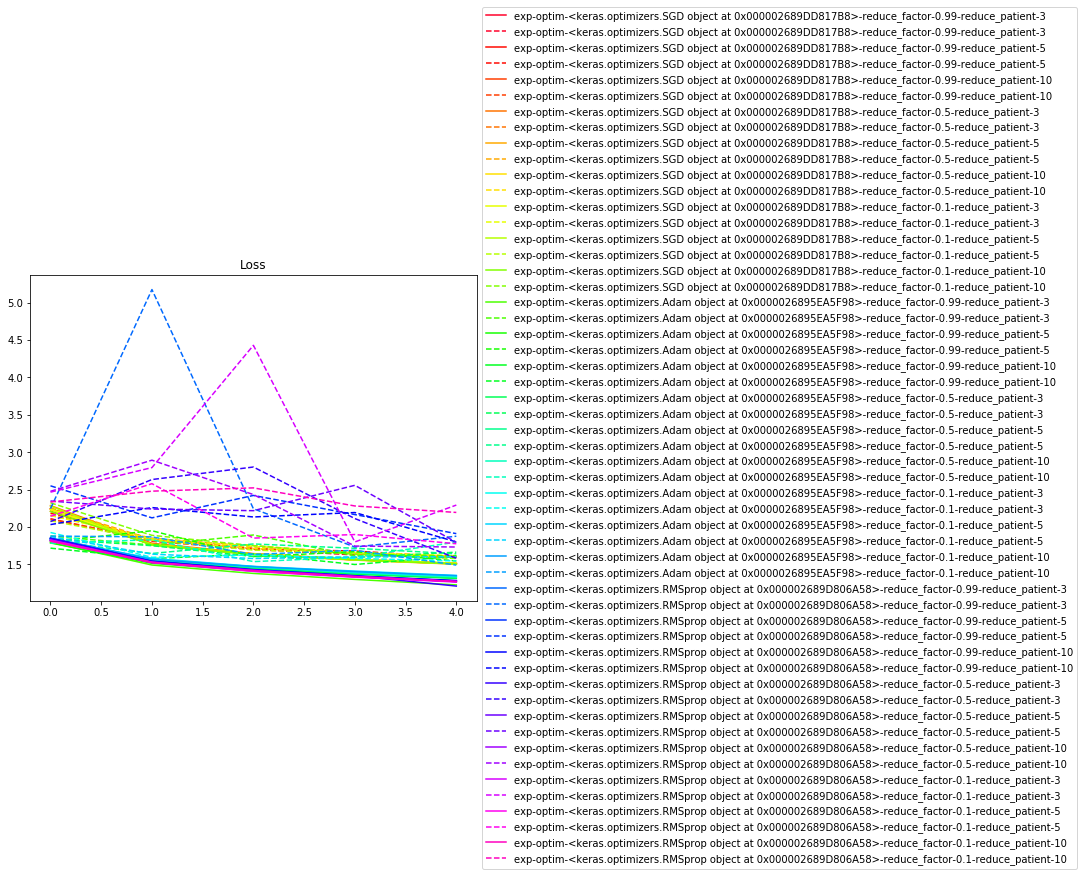

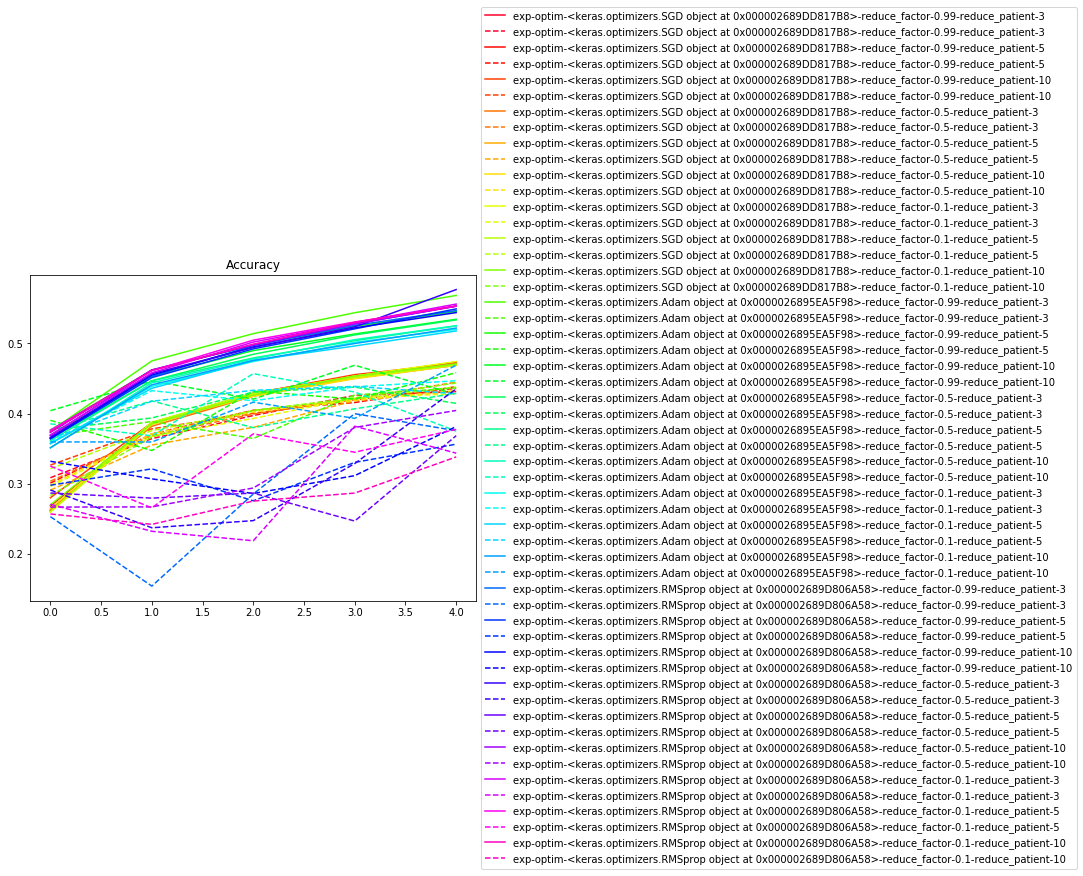

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()